# Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial is to generate and prove correctness of modeling and inversion capability in Devito for variable density visco- acoustics using an energy conserving form of the wave equation. We will use a simple form of dissipation only Q attenuation that allows unifying modeling physics in the interior and the absorbing boundary region. We also describe how the linearization of an energy conserving *skew self adjoint* system with respect to modeling parameters allows using the same modeling system for both forward and adjoint evolutions. This notebook is the first in a series, continuing with VTI and TTI anisotropic systems. 

We begin with the *skew self adjoint* form of the variable density scalar acoustic wave equation with dissipation only Q. The dissipation only (no dispersion) attenuation term used below $\left (\frac{\displaystyle \omega}{Q} \frac{\displaystyle \partial}{\displaystyle \partial t} P \right)$ is an approximation of a [Maxwell Body](https://en.wikipedia.org/wiki/Maxwell_material) -- that is to say viscoelasticity approximated with a spring and dashpot in series. In practice this approach for attentuating outgoing waves is very similar to the Cernan style damping in absorbing boundaries used elsewhere in Devito (**needs link**). 

The derivation of the attenuation model is not in scope for this tutorial, but one important point is that the physics in the absorbing boundary region and the interior of the model are *unified*, allowing the same modeling equations to be used everwhere, with physical Q values in the interior tapering to small Q at the boundaries to attentuate outgoing waves. 

## Table of symbols


| Symbol &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
| :---         | :---              | :--- |
| $\omega = 2 \pi f$ | center angular frequency | constant |
| $v(x,y,z)$   | P wave velocity    | function of space |
| $b(x,y,z)$   | buoyancy $(1 / \rho)$ | function of space |
| $Q(x,y,z)$   | Attenuation at frequency $\omega$ | function of space |
| $P(t,x,y,z)$ | Pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source term        | function of time, localized in space |
| $\overrightarrow{\partial x},\overrightarrow{\partial y},\overrightarrow{\partial z}$ | + shifted first derivative wrt $x,y,z$ | shifted 1/2 cell forward in space |
| $\overleftarrow{\partial x},\overleftarrow{\partial y},\overleftarrow{\partial z}$ | - shifted first derivative wrt $x,y,z$ | shifted 1/2 cell backward in space |

## SSA variable density visco- acoustic wave equation

$$
\frac{b}{v^2} \left( \frac{\omega}{Q} \frac{\partial}{\partial t} P +
    \frac{\partial^2}{\partial t^2} P \right) =
    \overleftarrow{\partial x}\left(b\ \overrightarrow{\partial x} P \right) +
    \overleftarrow{\partial y}\left(b\ \overrightarrow{\partial y} P \right) +
    \overleftarrow{\partial z}\left(b\ \overrightarrow{\partial z} P \right) + s 
    \tag{1}
$$

An advantage of this *skew self adjoint* form of the wave equation is that with modified source term $s$, the same system (1) can be used to provide stable modes of propagation for all operations needed in quasi- Newton optimization: 

- the nonlinear forward 
- the linearized forward (Jacobian forward)
- the linearized adjoint (Jacobian adjoint)

This advantage is more important for anisotropic operators, where widely utilized non energy conserving formulations can provide unstable adjoints and thus unstable gradients for anisotropy parameters.  

The *skew self adjoint* formulation is evident in the shifted spatial derivatves, with the derivative on the right side $\overrightarrow{\partial}$ shifting forward in space one-half cell, and the derivative on the left side $\overleftarrow{\partial}$ shifting backward in space one-half cell. $\overrightarrow{\partial}$ and $\overleftarrow{\partial}$ are anti-symmetric (also known as skew symmetric), meaning that for two random vectors $x_1$ and $x_2$:

$$
x_2 \cdot \left( \overrightarrow{\partial x}\ x_1 \right) \approx -\ 
x_1 \cdot \left( \overleftarrow{\partial x}\ x_2 \right) 
\tag{2}
$$

Below we will demonstrate this skew symmetry with a simple unit test on Devito shifted first derivatives. 

In the following notebooks in this series, material parameters *sandwiched* between the derivatives -- including anisotropy parameters -- become much more interesting, but here buoyancy $b$ is the only material parameter in the RHS of equation (1). 

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [22]:
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer
%matplotlib inline
mpl.rc('font', size=14)

# We also define 32 bit floating point as the precision type 
dtype = np.float32

## Unit test demonstrating skew symmetry for shifted derivatives

As noted above, we will demonstrate with a small 1D unit test and 8th order spatial operator that the devito shifted first derivatives are skew symmetric. This anti-symmetry can demonstrated for the forward and backward half cell shift first derivative operators $\overrightarrow{\partial}$ and $\overleftarrow{\partial}$ with two random vectors $x_1$ and $x_2$ by verifying the following *dot product test* equation (2) written above.

In [23]:
# Make small 1D function to test derivatives 
n_1d = 101
d_1d = 1.0
shape_1d = (n_1d,)
spacing_1d = (1/(n_1d-1),)   
origin_1d = (0.,)
extent_1d = (d_1d*(n_1d-1),)

# Initialize Devito grid and Functions for input(2) and output(2)
grid_1d = Grid(shape=shape_1d, extent=extent_1d, origin=origin_1d, dtype=dtype)
x = grid_1d.dimensions[0]
f1 = Function(name='f1', grid=grid_1d, space_order=8)
f2 = Function(name='f2', grid=grid_1d, space_order=8)
g1 = Function(name='g1', grid=grid_1d, space_order=8)
g2 = Function(name='g2', grid=grid_1d, space_order=8)

# Fill f1 and g1 with random values in [-1,+1]
f1.data[:] = -1 + 2 * np.random.rand(n_1d,)
g1.data[:] = -1 + 2 * np.random.rand(n_1d,)

# Equation defining: f2 = forward 1/2 cell shift derivative applied to f1
equation_f2 = Eq(f2, getattr(f1,'dx')(x+0.5*x.spacing))

# Equation defining: g2 = backward 1/2 cell shift derivative applied to g1
equation_g2 = Eq(g2, getattr(g1,'dx')(x-0.5*x.spacing))

# Define an Operator to implement these equations and execute
op = Operator([equation_f2, equation_g2])
op()

# Compute the dot products and the relative error
f1g2 = + np.dot(f1.data, g2.data)
g1f2 = - np.dot(g1.data, f2.data)   # skew symmetry requires this minus sign
diff = (f1g2-g1f2)/(f1g2+g1f2)

print("f1g2,g1f2,diff; %+12.8e %+12.8e %+12.8e" % (f1g2, g1f2, diff))

# At last the unit test
# Assert these dot products are float epsilon close in relative error
assert np.isclose(diff, 0, atol=1e-6)

Operator `Kernel` run in 0.01 s


f1g2,g1f2,diff; +1.18745196e+00 +1.18745136e+00 +2.50977166e-07


## Show the finite difference operators and c++ code generated by Devito

You can inspect the finite difference coefficients and locations these are evaluated with the code shown below. 

Note that you dont need to inspect the generate code, but Devito provides the option to use this highly optimized code in applications that do not need or require python.

In [24]:
# Show the FD coefficients/locations for the forward 1/2 cell shifted first derivative operator
print("\n\n+1/2 cell shift;")
print("..................................")
print(f1.dx(x0=x+0.5*x.spacing).evaluate)

# Show the FD coefficients/locations for the backward 1/2 cell shifted first derivative operator
print("\n\n-1/2 cell shift;")
print("..................................")
print(f1.dx(x0=x-0.5*x.spacing).evaluate)

# Show the generated c++ code generated by Devito for applying both forward and backward 
# 1/2 cell shifted derivatives
print("\n\nGenerated c++ code;")
print("..................................")
print(op.ccode)



+1/2 cell shift;
..................................
-1.19628906*f1(x)/h_x + 0.000697544643*f1(x - 3.0*h_x)/h_x - 0.0095703125*f1(x - 2.0*h_x)/h_x + 0.0797526042*f1(x - 1.0*h_x)/h_x + 1.19628906*f1(x + 1.0*h_x)/h_x - 0.0797526042*f1(x + 2.0*h_x)/h_x + 0.0095703125*f1(x + 3.0*h_x)/h_x - 0.000697544643*f1(x + 4.0*h_x)/h_x


-1/2 cell shift;
..................................
1.19628906*f1(x)/h_x + 0.000697544643*f1(x - 4.0*h_x)/h_x - 0.0095703125*f1(x - 3.0*h_x)/h_x + 0.0797526042*f1(x - 2.0*h_x)/h_x - 1.19628906*f1(x - 1.0*h_x)/h_x - 0.0797526042*f1(x + 1.0*h_x)/h_x + 0.0095703125*f1(x + 2.0*h_x)/h_x - 0.000697544643*f1(x + 3.0*h_x)/h_x


Generated c++ code;
..................................
#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double

## Doing some algebra to solve for the time update

The next step in implementing our Devito modeling operator to define the equation used to update time. What follows is a bit of algebra using the wave equation and finite difference approximations to time derivatives in order to calculate the equation used to update the pressure wavefield forward in time $P(t+\delta t)$ from the current and previous pressure wavefields
$P(t)$ and $P(t-\delta t)$.

#### 1. Numerical approximation for $\frac{\displaystyle \partial^2}{\displaystyle \partial t^2}P$
The second order accurate centered approximation to the second time derivative involves three wavefields: $P(t-\delta t)$, $P(t)$, and $P(t+\delta t)$. 

$$
\frac{\partial^2}{\partial t^2} P = \frac{\displaystyle P(t+\delta t) 
    - 2 P(t) + P(t-\delta t)}{\displaystyle \delta t^2} 
$$

#### 2. Solve equation from step (1) for $P(t+\delta t)$
In order to advance our finite difference solution in time, we solve for the expression used to evalute $P(t+\delta t)$.

$$
P(t+\delta t) = \delta t^2 \frac{\displaystyle \partial^2}{\displaystyle \partial t^2} P 
    + 2 P(t) - P(t-\delta t)
$$

#### 3. Numerical approximation for $\frac{\displaystyle \partial}{\displaystyle \partial t}P$
The argument for using a backward approximation is a bit hand wavy, but goes like this: a centered or forward approximation for $\frac{\displaystyle \partial}{\displaystyle \partial t}P$ would involve the term $P(t+\delta t)$, and hence $P(t+\delta t)$ would appear at two places in equation (7) below, essentially making the form of the time update equation implicit. 

We are interested in explicit time stepping and so prefer the backward approximation for  $\frac{\displaystyle \partial}{\displaystyle \partial t}P$.  In practical application, our experience is that the use of the backward difference is more stable than forward or centered.

The first order accurate backward approximation to the first time derivative involves two wavefields: $P(t-\delta t)$, and $P(t)$. We can use this expression as is. 

$$
\frac{\partial}{\partial t} P = \frac{\displaystyle P(t) 
    - P(t-\delta t)}{\displaystyle \delta t}
$$

#### 4. Solve the wave equation for $\frac{\displaystyle \partial^2}{\displaystyle \partial t^2} P$

$$
\begin{aligned}
\frac{b}{v^2} \left( \frac{\omega}{Q} \frac{\partial}{\partial t} P +
    \frac{\partial^2}{\partial t^2} P \right) &=
    \overleftarrow{\partial x}\left(b\ \overrightarrow{\partial x} P \right) +
    \overleftarrow{\partial y}\left(b\ \overrightarrow{\partial y} P \right) +
    \overleftarrow{\partial z}\left(b\ \overrightarrow{\partial z} P \right) + s\\[5pt]
    \frac{\partial^2}{\partial t^2} P &=
    \frac{v^2}{b} \left[ 
        \overleftarrow{\partial x}\left(b\ \overrightarrow{\partial x} P \right) +
        \overleftarrow{\partial y}\left(b\ \overrightarrow{\partial y} P \right) +
        \overleftarrow{\partial z}\left(b\ \overrightarrow{\partial z} P \right) + s
    \right] 
    - \frac{\omega}{Q} \frac{\partial}{\partial t} P
\end{aligned}
$$

#### 5. Plug equations from steps (3) and (4) into equation from step (2)
Next we plug in the expression for $\frac{\displaystyle \partial^2}{\displaystyle \partial t^2} P$ from equation (6) and the expression for $\frac{\displaystyle \partial}{\displaystyle \partial t} P$ from equation (5) into the the time update expression for $P(t+\delta t)$ in equation (4).

$$
\begin{aligned}
    P(t+\delta t) &= \delta t^2 
        \frac{v^2}{b} \left[ 
            \overleftarrow{\partial x}\left(b\ \overrightarrow{\partial x} P \right) +
            \overleftarrow{\partial y}\left(b\ \overrightarrow{\partial y} P \right) +
            \overleftarrow{\partial z}\left(b\ \overrightarrow{\partial z} P \right) + s
        \right] \\[5pt]
        & \quad -\ \delta t^2 \frac{\omega}{Q}
            \left( \frac{\displaystyle P(t) - P(t-\delta t)}{\displaystyle \delta t} \right) 
            + 2 P(t) - P(t-\delta t)
\end{aligned}
$$

#### 6. Simplify ...

$$
\begin{aligned}
    P(t+\delta t) &=
        \frac{\delta t^2 v^2}{b} \left[ 
            \overleftarrow{\partial x}\left(b\ \overrightarrow{\partial x} P \right) +
            \overleftarrow{\partial y}\left(b\ \overrightarrow{\partial y} P \right) +
            \overleftarrow{\partial z}\left(b\ \overrightarrow{\partial z} P \right) + s
        \right] \\[5pt]
        &\quad +\ P(t) \left(2 - \frac{\delta t^2 \omega}{Q} \right)
        - P(t-\delta t) \left(1 - \frac{\delta t\ \omega}{Q} \right)
\end{aligned}
$$

#### 7. et voila ...
The last equation from step (6) is the expression we will use to update the pressure wavefield at each time step. It depends on the pressure wavefield at the current time step $P(t)$, and the pressure wavefield at the previous time step $P(t-\delta t)$. 

The main work of the finite difference time stepping is evaluating the nested spatial derivative operators on the RHS of this equation. The particular advantage of Devito symbolic optimization is that Devito is able to solve for the complicated expressions that result from substituting the discrete forms of high order numerical finite difference approximations for the nested spatial derivatives seen in the last equation.

We have now completed the maths required to implementat the modeling operator. The remainder of this notebook deals with setting up and using the required Devito objects.

## Instantiate the Devito grid for a two dimensional problem

Define the dimensions and coordinates for the model. The computational domain of the model is surrounded by an *absorbing boundary region* where we implement boundary conditions to elimnate outgoing waves. We define the sizes for the interior of the model ```nx``` and ```nz```, the width of the absorbing boundary region ```npad```, and the sizes for the entire model padded with absorbing boundaries become ```nxpad = nx + 2*npad``` and ```nzpad = nz + 2*npad```.

In [25]:
# Define dimensions for the interior of the model
nx,nz = 501,501
dx,dz = 10.0,10.0                # Grid spacing in m
shape = (nx, nz)                 # Number of grid points
spacing = (dx, dz)               # Domain size is now 5 km by 5 km
origin = (0., 0.)                # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define dimensions for the model padded with absorbing boundaries
npad        = 50                 # number of points in absorbing boundary region (all sides)
nxpad,nzpad = nx+2*npad, nz+2*npad
shape_pad   = np.array(shape) + 2 * npad
origin_pad  = tuple([o - s*npad for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

# Initialize the Devito grid 
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent_pad[0]/(shape_pad[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent_pad[1]/(shape_pad[1]-1)))
grid = Grid(extent=extent_pad, shape=shape_pad, origin=origin_pad, dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("shape_pad;       ", shape_pad)
print("origin_pad;      ", origin_pad)
print("extent_pad;      ", extent_pad)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

shape;            (501, 501)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (5000.0, 5000.0)

shape_pad;        [601 601]
origin_pad;       (-500.0, -500.0)
extent_pad;       (6000.0, 6000.0)

grid.shape;       (601, 601)
grid.extent;      (6000.0, 6000.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


## Define the acquisition geometry: locations of sources and receivers 

**source**:
- X coordinate: left edge of the model
- Z coordinate: 1 cell below the top of the absorbing boundary

**receivers**:
- X coordinate: nx on-grid receivers across the top of the model 
- Z coordinate: 1 cell below the top of the absorbing boundary

In [26]:
# Source at top left edge of model 
src_coordinates = np.empty((1, 2))
src_coordinates[0, 0] = dx * (nx//2)
src_coordinates[0, 1] = dz * (nz//2)

# line of receivers across top of model
rec_coordinates = np.empty((nx, 2))
rec_coordinates[:, 0] = np.linspace(0.0, dx*(nx-1), nx)
rec_coordinates[:, 1] = dz

print("src_coordinate  X;         %+12.4f" % (src_coordinates[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src_coordinates[0,1]))
print("src_coordinates X min/max; %+12.4f %+12.4f" % (np.min(rec_coordinates[:,0]), np.max(rec_coordinates[:,0])))
print("src_coordinates Z min/max; %+12.4f %+12.4f" % (np.min(rec_coordinates[:,1]), np.max(rec_coordinates[:,1])))

src_coordinate  X;           +2500.0000
src_coordinate  Z;           +2500.0000
src_coordinates X min/max;      +0.0000   +5000.0000
src_coordinates Z min/max;     +10.0000     +10.0000


## Define velocity and buoyancy model parameters

We have the following constants and fields from equation (1) that we define as time invariant using ```Functions```:

| &nbsp; Symbol &nbsp; | Description |
|:---:|:---|
| $v(x,z)$ | Acoustic velocity |
| $$b(x,z)=\frac{1}{\rho(x,z)}$$ | Buoyancy (reciprocal density) |

In [27]:
# Create the velocity and buoyancy fields. We use a halfspace of 1500 over 2000 m/s
#   - These fields are scalar constants, so we use Function to define them
#   - We specify space_order in order to establish the appropriate size halo on the edges 
space_order = 8
v = Function(name='v', grid=grid, space_order=space_order)
b = Function(name='b', grid=grid, space_order=space_order)

v.data[:,:nzpad//2] = 1.500    # upper layer, specified in m/s
v.data[:,nzpad//2:] = 2.000    # lowe layer, specified in m/s
b.data[:,:] = 1.0              # initially constant density specified in g/cm^2

## Plot velocity of the halfspace model

Next we plot the half-space velocity model for illustration. 
- The demarcation between interior and absorbing boundary is shown with a dotted white line
- The source is shown as a large red asterisk
- The extent of the receiver array is shown with a thick dashed green line

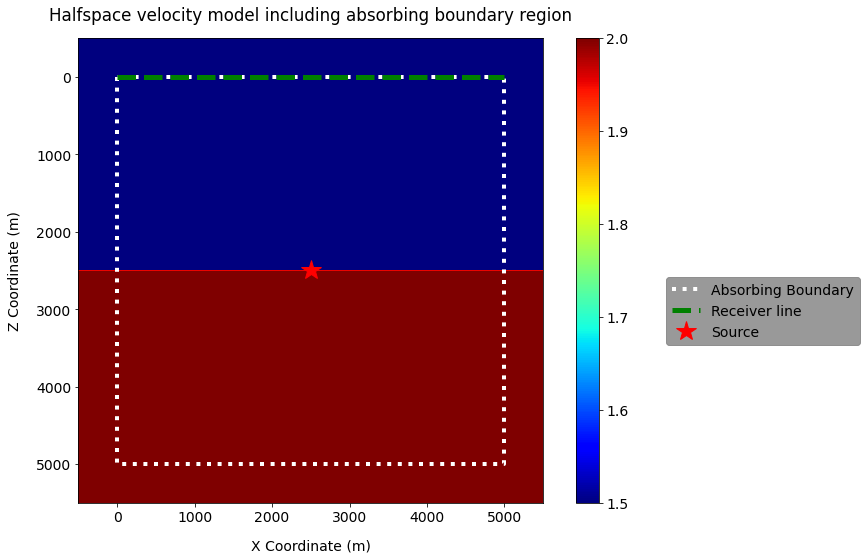

In [28]:
# note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + spacing[0]*(shape_pad[0]-1), 
              origin_pad[1] + spacing[1]*(shape_pad[1]-1), origin_pad[1]]

plt.figure(1, figsize=(12,8))
plt.clf()
plt.imshow(np.transpose(v.data), cmap=cm.jet, vmin=1.5, vmax=2.0, extent=plt_extent)
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]], 
         [origin[1], extent[1], extent[1], origin[1], origin[1]], 
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(rec_coordinates[:, 0], rec_coordinates[:, 1], 'green', linewidth=5, linestyle='--', label="Receiver line")
plt.plot(src_coordinates[:, 0], src_coordinates[:, 1], 'red', linestyle='None', marker='*', markersize=20, label="Source")
ax = plt.legend(bbox_to_anchor=(1.25, 0.5), loc='upper left')
ax.get_frame().set_color("gray")
plt.colorbar()
plt.xlabel("X Coordinate (m)", labelpad=15)
plt.ylabel("Z Coordinate (m)", labelpad=15)
plt.title("Halfspace velocity model including absorbing boundary region", y=1.025)
plt.tight_layout()
None

## Create the $\omega$/Q model used for dissipation only attenuation

We have the following constants and fields from equation (1) that we need to define and instantiate:

| &nbsp; Symbol &nbsp; | Description |
|:---:|:---|
| $\omega$      | Center angular frequency |
| $$\frac{1}{Q(x,z)}$$ | Inverse Q model used in the modeling system |

The strategy we use is designed to eliminate any corners or edges in the attentuation profile. We do this by making Q as a function of *distance from the **nearest** boundary*.

## Define a python function for setting w/Q array 

The python code in the function ```setup_wOverQ``` below uses the ```numpy.ogrid``` function, which allows an *outer product* over index arrays for the two dimensions to build up the attenuation profile. This approach is about 100x faster than using nested loops in python. This function is defined in the ```devito/examples/seismic/skew_self_adjoint``` directory but shown here for completeness.

In the next three cells we will:
1. Define a function for setting up the $\omega/Q(x,z)$ array
2. Use that function to establish the array we need to implement attenuation as a ```Function```
3. Plot the generated Q profile 

In [29]:
def setup_wOverQ(wOverQ, w, qmin, qmax, npad, sigma=npad//5):
    """
    Initialise spatially variable w/Q field used to implement attenuation and
    absorb outgoing waves at the edges of the model.

    Parameters
    ----------
    wOverQ : Function
        The omega over Q field used to implement attenuation in the model, 
        and the absorbing boundary condition for outgoing waves.
    w : float32
        center angular frequency, e.g. peak frequency of Ricker source wavelet 
        used for modeling.
    qmin : float32
        Q value at the edge of the model. Typically set to 0.1 to strongly 
        attenuate outgoing waves.
    qmax : float32
        Q value in the interior of the model. Typically set to 100 as a 
        reasonable and physically meaningful Q value.
    npad : int
        Number of points in the absorbing boundary region. Note that we expect 
        this to be the same on all sides of the model.
    sigma : float32
        sigma value for call to scipy gaussian smoother, default 5.
    """
    assert w > 0, "supplied w value [%f] must be positive" % (w)
    assert qmin > 0, "supplied qmin value [%f] must be positive" % (qmin)
    assert qmax > 0, "supplied qmax value [%f] must be positive" % (qmax)
    assert npad > 0, "supplied npad value [%f] must be positive" % (npad)
    
    t1 = timer()
    lqmin = np.log(qmin);
    lqmax = np.log(qmax);

    kxMin,kzMin = np.ogrid[:nxpad,:nzpad]
    kxArr,kzArr = np.minimum(kxMin,nxpad-1-kxMin),np.minimum(kzMin,nzpad-1-kzMin)
    nval1 = np.minimum(kxArr,kzArr)
    nval2 = np.minimum(1,nval1/(npad))
    nval3 = np.exp(lqmin+nval2*(lqmax-lqmin))
    wOverQ.data[:,:] = w / nval3

    if sigma > 0:
        wOverQ.data[:] = gaussian_smooth(wOverQ.data, sigma=sigma)

    # report min/max output Q value
    q1 = (np.min(1 / (wOverQ.data / w)))
    q2 = (np.max(1 / (wOverQ.data / w)))
    t2 = timer()
    print("setup_wOverQ ran in %.4f seconds -- min/max Q values; %8.4f %8.4f" % (t2-t1, q1, q2)) 

In [30]:
# Initialize the attenuation profile
fpeak = 0.010  # peak frequency 10Hz (0.010 kHz)
w = 2.0 * np.pi * fpeak
print("w,fpeak; ", w, fpeak)
qmin = 0.1
qmax = 100.0
wOverQ = Function(name='wOverQ', grid=grid, space_order=space_order)
setup_wOverQ(wOverQ, w, qmin, qmax, npad)

w,fpeak;  0.06283185307179587 0.01


Operator `smooth` run in 0.01 s


setup_wOverQ ran in 1.4916 seconds -- min/max Q values;   0.1593 100.0000


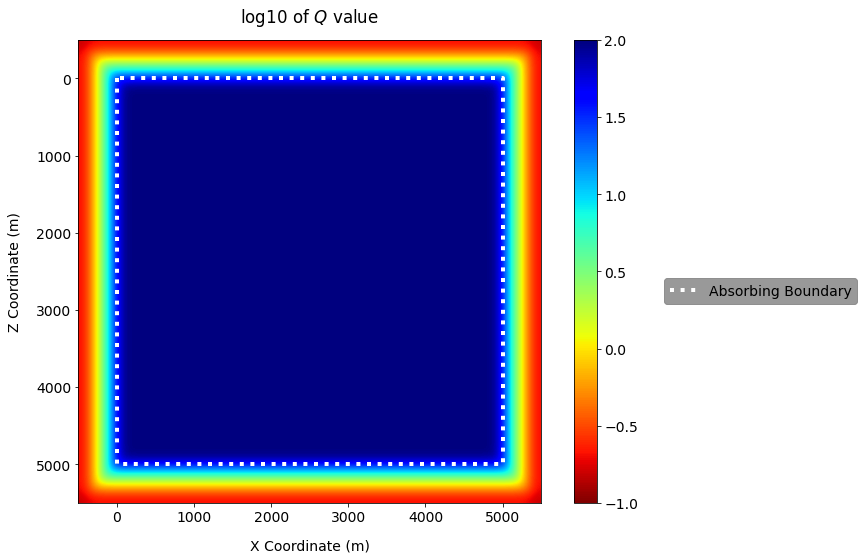

In [31]:
# Plot the generated Q profile
Q = np.log10(1 / (wOverQ.data / w)) 
plt.figure(1, figsize=(12,8))
plt.clf()
plt.imshow(np.transpose(Q), cmap=cm.jet_r, vmin=np.log10(qmin), vmax=np.log10(qmax), extent=plt_extent)
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]], 
         [origin[1], extent[1], extent[1], origin[1], origin[1]], 
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
ax = plt.legend(bbox_to_anchor=(1.25, 0.5), loc='upper left')
ax.get_frame().set_color("gray")
plt.xlabel("X Coordinate (m)", labelpad=15)
plt.ylabel("Z Coordinate (m)", labelpad=15)
plt.title("log10 of $Q$ value", y=1.025)
plt.colorbar()
plt.tight_layout()
None

## Define the simulation time range

In this notebook we run 1 second of simulation using the sample rate defined by the CFL condition as implemented in ```examples/seismic/model.py```.

We also use the convenience ```TimeRange``` as defined in ```examples/seismic/source.py```.

In [32]:
t0 = dtype(0.)        # Simulation time start
tn = dtype(1250.)     # Simulation time end (1 second = 1000 msec)
# cfl = 0.38     # Stability criteria for 2nd order acoustics
cfl = 0.2        # Stability criteria for 2nd order acoustics
dt  = dtype(dtype(cfl * np.min(spacing) / np.max(v.data)))
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min,max,dt,num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))

Time min,max,dt,num;   0.000000 2000.000000   1.000000 2001


## Define the source

We use a 10 Hz center frequency ```RickerSource``` wavelet source as defined in ```examples/seismic/source.py```. Note that we have defined the source coordinates above, and copy here into the strucure defined by ```RickerSource```.

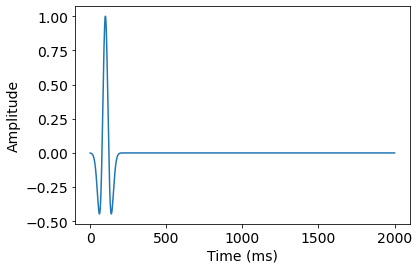

In [33]:
src = RickerSource(name='src', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src.coordinates.data[:] = src_coordinates

# We can plot the time signature to see the wavelet
src.show()

## Define the receivers

We use a ```Receiver``` as defined in ```examples/seismic/source.py```. Note that we have defined the receiver coordinates above, and copy here into the strucure defined by ```Receiver```.

In [34]:
rec = Receiver(name='rec', grid=grid, npoint=nx, time_range=time_range)
rec.coordinates.data[:] = rec_coordinates

## Define the pressure wavefield as a ```TimeFunction```

We specify the time_order as 2, which allocates 3 time steps in the pressure wavefield. As described elsewhere, Devito will use "cyclic indexing" to index into this multi-dimensional array.

In [35]:
# Define the TimeFunction
p = TimeFunction(name="p", grid=grid, time_order=2, space_order=space_order)

# Get the dimensions and spacing for t, x, z 
t,x,z = p.dimensions
h_t = t.spacing
h_x = x.spacing
h_z = z.spacing

## Define the source injection and receiver extraction 

In [36]:
# Finally we define the source injection and receiver extraction functions 
src_term = src.inject(field=p.forward, expr=src * h_t**2 * v**2 / b)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=p.forward)

## Finally, the Devito operator

We next transcribe the time update expression above into a Devito ```Eq```. Then we add the source injection and receiver extraction and build an ```Operator``` that will generate the c++ code for performing the model.

We copy the time update expression from above for clarity. Note we omit $s$ from the ```Eq``` below because we will be explicitly injecting the source using ```src_term```.

$$
\begin{aligned}
    P(t+\delta t) &=
        \frac{\delta t^2 v^2}{b} \left[ 
            \overleftarrow{\partial x}\left(b\ \overrightarrow{\partial x} P \right) +
            \overleftarrow{\partial y}\left(b\ \overrightarrow{\partial y} P \right) +
            \overleftarrow{\partial z}\left(b\ \overrightarrow{\partial z} P \right) + s
        \right] \\[5pt]
        &\quad +\ P(t) \left(2 - \frac{\delta t^2 \omega}{Q} \right)
        - P(t-\delta t) \left(1 - \frac{\delta t\ \omega}{Q} \right)
\end{aligned}
$$

In [37]:
# NBVAL_IGNORE_OUTPUT

eq_time_update = (h_t**2 * v**2 / b) * \
    ((b * p.dx(x0=x+h_x/2)).dx(x0=x-h_x/2) + \
     (b * p.dz(x0=z+h_z/2)).dz(x0=z-h_z/2)) + \
    p * (2 - h_t**2 * wOverQ) - p.backward * (1 - h_t * wOverQ)

stencil = Eq(p.forward, eq_time_update)

# op = Operator([stencil] + src_term + rec_term, subs=p.grid.spacing_map)
op = Operator([stencil] + src_term + rec_term)

In [38]:
# Print the arguments used in the signature for the the c++ generated code
# op.arguments()

In [39]:
# Print the generated c++ code
# print(op)

In [40]:
# run the operator
print("v        min/max; %+12.6e %+12.6e" % (np.min(v.data), np.max(v.data)))
print("b        min/max; %+12.6e %+12.6e" % (np.min(b.data), np.max(b.data)))
print("wOverQ   min/max; %+12.6e %+12.6e" % (np.min(wOverQ.data), np.max(wOverQ.data)))
print("time_range.num; ", time_range.num)

print(time_range)
print("dt; ", dt)
# op(time=time_range.num-1, h_x=dx, h_z=dz, dt=dt)
summary = op(time=time_range.num-1, h_x=dx, h_z=dz, dt=dt)
print(summary)
# print("rec.data min/max; %+12.6e %+12.6e" % (np.min(rec.data), np.max(rec.data)))

v        min/max; +1.500000e+00 +2.000000e+00
b        min/max; +1.000000e+00 +1.000000e+00
wOverQ   min/max; +6.283185e-04 +3.944902e-01
time_range.num;  2001
TimeAxis: start=0, stop=2000, step=1, num=2001
dt;  1.0


Operator `Kernel` run in 3.86 s


PerformanceSummary([(PerfKey(name='section0', rank=None), PerfEntry(time=3.813433999999979, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])), (PerfKey(name='section1', rank=None), PerfEntry(time=0.0008600000000000137, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])), (PerfKey(name='section2', rank=None), PerfEntry(time=0.03571299999999993, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])


## Plot the computed wavefield

No handles with labels found to put in legend.


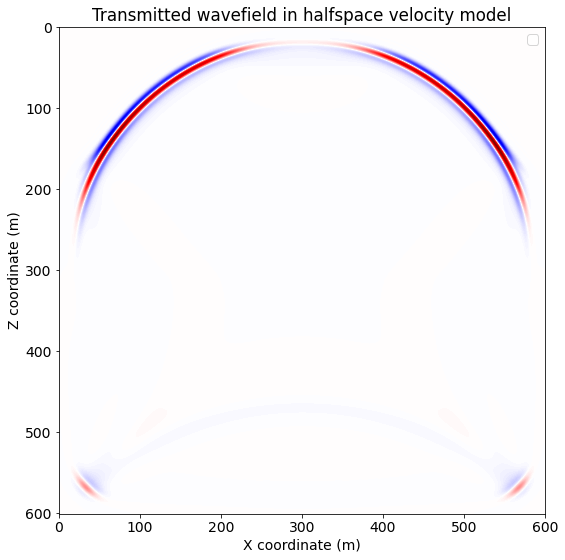

In [41]:
# Plot wavefield and source/rec position
plt.figure(figsize=(8,8))
amax = np.max(np.abs(p.data[1,:,:]))
plt.imshow(np.transpose(p.data[1,:,:]), vmin=-amax, vmax=+amax, cmap="seismic")
plt.legend()
plt.xlabel('X coordinate (m)')
plt.ylabel('Z coordinate (m)')
plt.title('Transmitted wavefield in halfspace velocity model')
plt.tight_layout()
# plt.savefig('wavefieldperf.pdf')


In [42]:
# # Define the TimeFunction
# p = TimeFunction(name="p", grid=grid, time_order=2, space_order=space_order)

# # Get the dimensions and spacing for t, x, z 
# t,x,z = p.dimensions
# h_t = t.spacing
# h_x = x.spacing
# h_z = z.spacing

# # the partial differential equation
# pde = (b / v**2) * (wOverQ * p.dt(x0=t-0.5*h_t) + p.dt2) -\
#         (b * p.dx(x0=x+0.5*h_x)).dx(x0=x-0.5*h_x) -\
#         (b * p.dz(x0=z+0.5*h_z)).dz(x0=z-0.5*h_z)

# pde

# t1 = timer()
# stencil = Eq(p.forward, solve(pde, p.forward))
# t2 = timer()
# print("solve ran in %.4f seconds." % (t2-t1)) 
# stencil

## References

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf

## questions
- use of src/rec two different ways
- should I show the output from solve() on the pde? It is pretty infomative